# `GenericSeries` Tutorial

## Introduction

The `GenericSeries` class describes a potentially multi-dimensional quantity that depends on one or more dimensions.
Some examples are the position of the welding torch that depends on time or the workpiece temperature field that depends on time and space.
The data of the `GenericSeries` can either be stored in form of explicit values or as a mathematical expression.
It's main feature is that you can evaluate the data at any given coordinate of the dimensions it depends on.
This happens either through interpolation if the data is discrete or through direct evaluation of the mathematical expression.
We can use the `GenericSeries` in our scripts and jupyter notebooks by importing it from the WelDX python package:

In [1]:
from weldx import GenericSeries

For this tutorial, we will also need to import the following packages and classes:

In [2]:
from weldx import Q_
from xarray import DataArray
from pint import DimensionalityError

import matplotlib.pyplot as plt
import numpy as np

## Terminology

Before we can start with the actual tutorial, we need to discuss some terminology.
It is essential to understand the differences between the following terms to avoid confusion throughout the course of this tutorial.

**Dimension**

Each dimension describes a single degree of freedom. 
We can think of it as a 1d-coordinate axis. 
Using multiple dimensions will create a multi-dimensional space. 
A typical example would be the dimensions $x$, $y$, and $z$ that form 3d-space. 
Another popular dimension is time.

**Coordinates**

A coordinate is a specific value or label on the 1d-axis of a dimension. 
We can specify the location of a point in 3d-space by providing its coordinates. 
For example, we can use $x=1m$, $y=3m$, and $z=0m$.
These are coordinates for the dimensions $x$, $y$, and $z$.
Dimensions represent degrees of freedom, coordinates are discrete values of a dimension.

**Variable**

If a mathematical expression is used to describe the `GenericSeries`, the individual terms of this expression can be divided into two groups. 
The first group are variables. 
Variables are symbols that don't get values assigned to them during the creation of a `GenericSeries`.
They let us evaluate the expression for differen coordinates.
Consider the following expression:

$$
2 \cdot x + 3
$$

Here, $x$ is our variable. 
We can evaluate this expression over and over again by providing differen values/coordinates for $x$.
For example, if we would use $x=2$, the result is $7$. 
With $x=4$ we would get $11$. 
An important fact to note is that each variable of a `GenericSeries`' expression is a dimension. 
But not every dimension of an expression is necessarily represented by a variable.
We will show some code examples later that make this more understandable.

**Parameter**

The second group of therms in an expression based `GenericSeries` are parameters.
Parameters are also symbols of an expression, but in contrast to variables, they already get discrete values assigned to them.
Consider the following expression:

$$
a \cdot t + b
$$

with:

$$
\begin{matrix}
a=&3m/s\\
b=&5m
\end{matrix}
$$

$a$ and $b$ are parameters, because they have values assigned to them. 
`t` is still a variable

## Discrete data

### Construction

As mentioned in the introduction, the `GenericSeries` can either describe a dimension dependent quantity by a set of discrete values or a mathematical expression.
We will start this tutorial with discrete values.

Let's say we we want to describe the temperature of a specimen along our welding groove during a single pass welding experiment.
The spatial direction along the groove is the dimension `x`.
Time is represented by the dimension `t`.
We have measured the temparature at 4 differrent points in time and at 6 different positions.
Our data measured in Kelvin is:

In [3]:
t_0 = [300, 300, 300, 300, 300, 300]
t_1 = [800, 1200, 400, 300, 300, 300]
t_2 = [450, 500, 600, 800, 1200, 400]
t_3 = [412, 425, 450, 500, 600, 800]

data = Q_([t_0, t_1, t_2, t_3], "K")

We also know the coordinates of the data in `x` and `t`:

In [4]:
coords_t = Q_([0, 10, 20, 30], "s")
coords_x = Q_([0, 5, 10, 15, 20, 25], "cm")

Here is a quick plot of our temperature data:

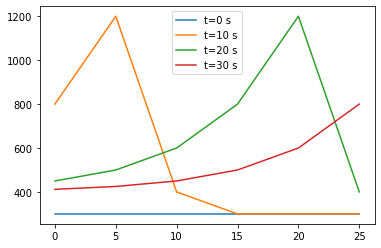

In [5]:
plt.plot(
    coords_x.m, np.transpose(data.m),
    label=[f"t={v}" for v in coords_t]
)
plt.gca().legend()

Now we can create our `GenericSeries` an follows:

In [6]:
gs_discrete = GenericSeries(
    data=data, 
    dims=["t", "x"], 
    coords={"t":coords_t, "x":coords_x}
)
gs_discrete

<GenericSeries>
Values:
[[ 300  300  300  300  300  300]
 [ 800 1200  400  300  300  300]
 [ 450  500  600  800 1200  400]
 [ 412  425  450  500  600  800]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int32 0 10 20 30
  * x        (x) int32 0 5 10 15 20 25
Units:
	K

> TODO: Check and update discret __repr__ -> do not print all values, don't print Coordinates twice

The first argument is the raw data.
`dims` expects a list of strings that we can use to give our dimensions names.
With `coords` we provide the coordinates of our discrete values.
`dims` and `coords` are optional.
If you don't provide dimension names, the `GenericSeries` will use default names:

In [7]:
GenericSeries(data=data).dims

('dim_0', 'dim_1')

If you are already familiar with the `xarray` python package, you might have noticed the similarities between the construction of a `GenericSeries` and an `xarray.DataArray`.
In fact, the discrete version of the `GenericSeries` is based on an `xarray.DataArray` and they share some interfaces with comparable behavior.

### Accessing data

If you want to access a single item you can use the `[]` operator to select elemets by index:

In [8]:
gs_discrete[3,4]

<xarray.DataArray ()>
<Quantity(600, 'kelvin')>
Coordinates:
    t        int32 30
    x        int32 20

Slicing is also possible:

In [9]:
gs_discrete[2:4,:]

Magnitude,[[ 450 500 600 800 1200 400] [ 412 425 450 500 600 800]]
Units,K


> TODO: implement and demonstrate sel function like in xarray

## Evaluation/Interpolation

Even though the `GenericSeries` might be based on discrete values, you should think of it as some kind of mathematical function object that can be evaluated at any coordinate along its dimensions.
To do so, we simply use the call operator `()` on our `GenericSeries` and specify the coordinates we are interested in.
For example, we might be interested in the temperature at $x=12cm$ and $t=24s$.
The coordinates are passed as keyword arguments where the key is the dimension and the value are the coordinates we are interested in:

> **TODO: Really IMPORTANT** -> We need to assure that the units at the coordinates are used correctly. Currently only the magnitude is taken. So using "nm" or "m" instead of "cm" has no effect on the result. I could even use a totally unrelated unit without any problems


In [46]:
gs_discrete(t="24s", x="12cm")

<GenericSeries>
Values:
[[596.]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 24
  * x        (x) int64 12
Units:
	K

It is not necessary to provide coordinates for all dimensions.
A single dimension is already enough:

In [11]:
gs_discrete(t="24s")

<GenericSeries>
Values:
[[434.8 470.  540.  680.  960.  560. ]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 24
  * x        (x) int64 0 5 10 15 20 25
Units:
	K

> TODO: check dim removal

Of cause, we can also evaluate multiple coordinate values for each dimension:

In [12]:
gs_discrete(t=Q_([11, 23], "s"), x=Q_([3, 14, 22], "cm"))

<GenericSeries>
Values:
[[984.   364.   358.  ]
 [461.94 679.   820.  ]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 11 23
  * x        (x) int64 3 14 22
Units:
	K

You may have noticed that we exclusively used coordinate values that do not match the coordinates we initially provided to the `GenericSeries`.
The actual data values are obtained by interpolation.
By default, the `GenericSeries` uses linear interpolation.
It can be changed during construction using the `interpolation` parameter or by assigning a new value using the `interpolation` setter:

> TODO: mention interpolation outside of boundaries

In [13]:
gs_discrete.interpolation = "linear"

Let's interpolate the data for $t=15s$ and plot it together with the two closest timesteps:

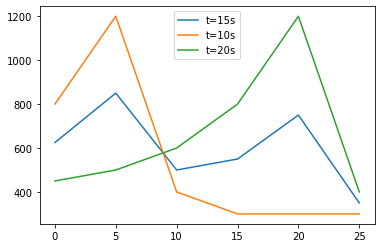

In [14]:
plt.plot(coords_x.m, np.transpose(gs_discrete(t="15s").data[0].m), label="t=15s")
plt.plot(
    coords_x.m, np.transpose(gs_discrete[1:3].data.m), 
    label=[f"t={v}s" for v in gs_discrete.data_array.t[1:3].data]
)
plt.gca().legend();

As one might expect the linearly interpolated data is the mean value of both curves since $t=15s$ lies directly in the middle between $t=10s$ and $t=20s$.
However, that doesn't really look like the correct temperature distrubution for a single torch moving along the groove.
Instead the peak value should translate from left to right.
Of cause, with dense data from real measurements, this would be just a minor issue with no practical relevance, but it serves as a nice transition two our next topic.

## Using Expressions

### A simple example

Another way to define a `GenericSeries` is using mathematical expressions.
In contrast to the previously shown approach we do not need to generate and store a lot of discrete data.
All we need is a simple formula.
Additionally, we do not get interpolation errors as in the previous section since we can evaluate the expression exactly for any given set of coordinates.

Let's start with a more or less simple example where we try to depict the data from the previous section as an expression.
Note that we are not thriving for an exact match of the values, since this is only an example of the `GenericSeries`'s features.
The following equation resembles a wave that travels towards increasing $x$ values with increasing v $t$:

$$
f\left(x,t\right)=\mathrm{tanh}\left(\frac{x-t}{5}\right) - \mathrm{tanh}\left(x-t-10\right)
$$

Like in the previous section, the slope on the right-hand side of the peak is much steeper.
We now translate this equation into an expression string that can be understood by the `GenericSeries`:

In [15]:
expr = "tanh((x-t)/5) - tanh(x-t-10)"

The syntax is pretty close to python code, except that it is enclosed inside of a string.
Now we could create a `MathematicalExpression` using this expression string and pass it to the `GenericSeries`, but it is much easier to simply pass the string directly to the `GenericSeries`:

> TODO Link MathExpr tutorial

In [16]:
gs_expr=GenericSeries(expr)

We have now created a `GenericSeries` based on an expression.
Wasn't that hard, right?
Let's print it and have a look at its representation:

In [17]:
gs_expr

<GenericSeries>

Expression:
	 tanh(-t/5 + x/5) - tanh(-t + x - 10)
Parameters:
	NoneDimensions:
	['x', 't']
Units:
	

> TODO: fix __repr__

The first item of the output is the expression we entered, but there are also the fields `Parameters`, `Dimensions`, and `Units`.
Our current `GenericSeries` has no parameters (see terminology at the beginning) since we did not define any so far.
The dimensions `x` and `t` were automatically extracted from the provided expression.
The field `Units` refers to the units our quantity after we evaluated the expression.
As you can see, the field is currently empty and we will soon understand why this is the case.
But first, we will evaluate our equation as we did before with the discrete version, except that we will not use units here.
Again, we will talk about this later.

In [18]:
coords_t = [-5, 5, 15]
coords_x = list(range(25))
result = gs_expr(t=coords_t, x=coords_x)
result

<GenericSeries>
Values:
[[ 1.76150336e+00  1.83298391e+00  1.88040640e+00  1.88569613e+00
   1.70840017e+00  9.64027580e-01  2.14148974e-01  1.96472776e-02
  -6.02735149e-03 -6.69777954e-03 -4.85445058e-03 -3.30531381e-03
  -2.22340901e-03 -1.49183260e-03 -1.00037175e-03 -6.70696139e-04
  -4.49632983e-04 -3.01420641e-04 -2.02058378e-04 -1.35448298e-04
  -9.07957372e-05 -6.08631138e-05 -4.07981746e-05 -2.73480182e-05
  -1.83320074e-05]
 [ 2.38405844e-01  3.35963230e-01  4.62950433e-01  6.20051038e-01
   8.02624679e-01  9.99999996e-01  1.19737529e+00  1.37994874e+00
   1.53704790e+00  1.66402448e+00  1.76150336e+00  1.83298391e+00
   1.88040640e+00  1.88569613e+00  1.70840017e+00  9.64027580e-01
   2.14148974e-01  1.96472776e-02 -6.02735149e-03 -6.69777954e-03
  -4.85445058e-03 -3.30531381e-03 -2.22340901e-03 -1.49183260e-03
  -1.00037175e-03]
 [ 4.94524631e-03  7.36847980e-03  1.09725978e-02  1.63251423e-02
   2.42568700e-02  3.59724199e-02  5.31939872e-02  7.83314456e-02
   1.14648352e

The result is a new `GenericSeries` with discrete values at the coordinates we provided.
Let's create a plot from the data:

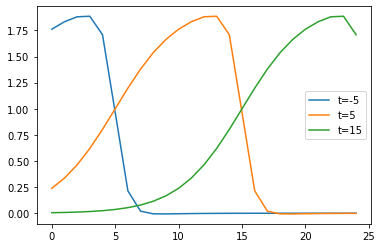

In [19]:
plt.plot(
    result.data_array.x,
    np.transpose(result.data.m),
    label=[f"t={v}" for v in result.data_array.t.data]
)
plt.gca().legend();

### Adding parameters

While we can already recognize in the previous plot, that it has some similarities with the plot of the discrete data, a look at the y-axis tells us, that the magnitudes do not match.
We will correct this by multiplying with a scaling factor `s` and adding an offset `o`.
The new expression is:

In [20]:
expr_param = "s * (tanh((x-t)/5) - tanh(x-t-10)) + o"

So far, there is nothing that distincts `s` and `o` from `x` and `t`.
They are just another set of symbols in our equation.
We will declare `s` and `o` as expression parameters during the construction of our `GenericSeries` using the `parameters` argument.
It expects a dictionary, that maps a discrete value to any of our expressions symbols.
Let us now do this for `s` and `o`:

In [21]:
gs_expr_param = GenericSeries(
    expr_param, 
    parameters=dict(s=450, o=300),
)
gs_expr_param

<GenericSeries>

Expression:
	 o + s*(tanh(-t/5 + x/5) - tanh(-t + x - 10))
Parameters:
	s = 450
	o = 300
Dimensions:
	['x', 't']
Units:
	

As you can see, `s` and `o` now appear in the `Parameters` section together with the values we assigned to them while `t` and `x` are still variables.
If we plot the new `GenericSeries` at the same coordinates as before, we can see the effect of our modifications on the y-axis:

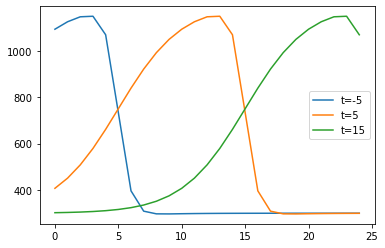

In [22]:
result_expr_param = gs_expr_param(t=coords_t, x=coords_x)
plt.plot(
    coords_x,
    np.transpose(result_expr_param.data.m),
    label=[f"t={v}" for v in coords_t],
)
plt.gca().legend();

### Adding units

The final piece we are missing so far in resembling the discrete data as expression are units.
We avoided them so far, because they make things a bit more complicated.
The problem is, that the units are evaluated at the same time as the numeric part which means that they actually need to be compatible during all operations.
Looking at our equation, $x-t$ already violates this constraint since we cant substract a time from a length.
Furthermore, the hyperbolic tangent requires an angular unit.
Luckily, the underlying unit system lets us get away with unitless numbers here, otherwise the prievious examples wouldn't have worked (we should mention at this point that plain numbers are implicitly cast to unitless quantities).
Last but not least, the resulting values should be in Kelvin.

We can solve these issues by simply introducing additional unit conversion parameters and adding the correct units to the existing ones.
In our example expression, we introduce the additional parameters `a` and `b` with the only purpose to turn the units of `x` and `t` into an angular unit (it would be enough to only strip the unit so that we get a unitless value, but let's do it the right way).
The expression now looks like this:

In [23]:
expr_units = "s * (tanh((a*x-b*t)/5) - tanh(a*x-b*t-10)) + o"

We define the values for the parameters as follows:

In [24]:
params_units = dict(
    s="450K",
    o="300K",
    a="rad/cm",
    b="rad/s"
)

Note that we added Kelvins as units to `s` and `o`.
If we now try to create a new, updated `GenericSeries`, we will still get an error:

In [25]:
try:
    GenericSeries(expr_units, parameters=params_units)
except ValueError:
    print("Still got an issue with the dimensions!")

Still got an issue with the dimensions!


The remaining problem here is that the `GenericSeries` doesn't know the units of our dimensions `x` and `t`.
Because we didn't specify that, it assumes they are dimensionless.
We can tell the `GenericSeries` what units those dimensions have by using the `units` input during initialization.
It requires a simple mapping between the dimension and its unit like in the following example.

In [26]:
gs_units = GenericSeries(
    expr_units, 
    parameters=params_units,
    units = dict(x="cm", t="s")
)
gs_units

<GenericSeries>

Expression:
	 o + s*(tanh(a*x/5 - b*t/5) - tanh(a*x - b*t - 10))
Parameters:
	s = 450 K
	o = 300 K
	a = 1.0 rad / cm
	b = 1.0 rad / s
Dimensions:
	['x', 't']
Units:
	K

> **Additional note:** Actually, the `GenericSeries` doesn't require a unit for a dimension, but a "dimensionality" like length, time, temperature etc. It has no real relevance if you would assign seconds, minutes or hours to a dimension since the unit will be scaled internally

Finally, we are able to construct our `GenericSeries` that also considers units.
As you can see, all the provided units are now listed in the output above.
Additionally, the output unit of the expression is now also listed under `Units` even though it was never explicitly specified.
The `GenericSeries` is able to determine it on its own from the information it already has.

> **TODO** Print dimension units as well

If we now want to evaluate the expression, we also have to provide the coordinates as quantities with a fitting unit, otherwise we get an error as the following example shows:

In [27]:
coords_t = [-5, 5, 15]
coords_x = [5, 10, 25]
try:
    gs_units(t=coords_t, x=coords_x)
except DimensionalityError:
    print("You forgot the units!")

You forgot the units!


Adding the correct units fixes the problem:

In [49]:
coords_t = Q_([-5, 5, 15], "h")
coords_x = Q_([5, 10, 25], "km")

gs_units(t=coords_t, x=coords_x)

<GenericSeries>
Values:
[[300. 300. 300.]
 [300. 300. 300.]
 [300. 300. 300.]]
Dimensions:
	('x', 't')
Coordinates:
	Coordinates:
  * x        (x) int32 5 10 25
  * t        (t) int32 -5 5 15
Units:
	K

In case you wonder, why all the output values are identical, have a look at the input units we used.
If you change them to `"s"` and `"cm"` you will see values that are more in line with the previous examples, but they demonstrate that it is not important which units you assign to the dimensions during initialization.
All that matters is the units "dimensinality".

### Parameter dimensions

When we discussed the terminology, we stated that all variables of an expression based `GenericSeries` are dimensions, but not all dimensions are variables.
We will now show you a dimension that is not a variable using a short example.
Consider the following linear equation:


In [29]:
expr_linear = "a*t + b"

`t` is our only variable and represents time.
`a` and `b` are parameters.
So far we only used scalar parameters, but nothing hinders us to use arrays as well:

In [30]:
GenericSeries(
    expr_linear,
    parameters=dict(a=Q_([1,3,5], "m/s"), b=Q_([5,6,7], "m")),
    units=dict(t="s"),
)

<GenericSeries>

Expression:
	 a*t + b
Parameters:
	a = [1 3 5] m / s
	b = [5 6 7] m
Dimensions:
	['t', 'dim_0']
Units:
	m

In the output above, we notice that we got an additional dimension we did not define: `dim_0`.
This happened because we used arrays for our parameters.
An array is another dimension with discrete values.
Since we did not define a dimension name, the `GenericSeries` assigned one itself, `dim_0`.
It also assumes that all provided parameters share the same dimensions.
But that doesn't have to be what we intended.
Maybe we wanted `a` and `b` to have different dimensions.
Therefore, we can also assign dimensions to parameters.
This can either be done by providing the parameter as a tuple consisting of value and dimension name or as an `xarray.DataArray`:

In [31]:
a = (Q_([1,3,5], "m/s"), "c")
b = DataArray(Q_([5,6,7], "m"), dims=["v"])

gs_array = GenericSeries(
    expr_linear,
    parameters=dict(a=a, b=b),
    units=dict(t="s"),
)
gs_array

<GenericSeries>

Expression:
	 a*t + b
Parameters:
	a = <xarray.DataArray (c: 3)>
<Quantity([1 3 5], 'meter / second')>
Dimensions without coordinates: c
	b = <xarray.DataArray (v: 3)>
<Quantity([5 6 7], 'meter')>
Dimensions without coordinates: v
Dimensions:
	['t', 'v', 'c']
Units:
	m

As you can see, we now have three dimensions, while only one is an actual variable of our expression.
If we evaluate the `GenericSeries`, the dimensions will be broadcastet and our result will be a new 3 dimensionel discrete `GenericSeries`.
But see for yourself:

In [32]:
gs_array(t=Q_([0, 1], "s"))

<GenericSeries>
Values:
[[[ 5  6  7]
  [ 6  7  8]]

 [[ 5  6  7]
  [ 8  9 10]]

 [[ 5  6  7]
  [10 11 12]]]
Dimensions:
	('c', 't', 'v')
Coordinates:
	Coordinates:
  * t        (t) int32 0 1
Units:
	m

> **todo** 
> - xarray parameters should not be printed as DataArray (clutters output)
> - Values of parameter dims should be assigned as coordinates
> - somehow print dimensions of parameters as well

Parameters can also have more than one dimension:

In [33]:
GenericSeries(
    expr_linear,
    parameters=dict(
        a=Q_([[0, 1], [2, 3]], "m/s"), 
        b=Q_([1, 2], "m"),
    ),
    units=dict(t="s")
)


<GenericSeries>

Expression:
	 a*t + b
Parameters:
	a = [[0 1] [2 3]] m / s
	b = [1 2] m
Dimensions:
	['t', 'dim_0', 'dim_1']
Units:
	m

Note that if you do not provide custom names for the dimensions, the `GenericSeries` will just enumerate them as in the example above.
The enumeration is always restarted for each parameter. 
So `b` would actually use the dimension `dim_0`.
To avoid any problems, always name your dimensions.
If you use a tuple to name the dimensions of a multi-dimensional parameter, the second value has to be a list of names, where the first name refers to the most outer dimension and the last one to the most inner:

In [34]:
GenericSeries(
    expr_linear,
    parameters=dict(
        a=(Q_([[0, 1], [2, 3]], "m/s"), ["c", "v"]),
        b=(Q_([1, 2], "m"), "v")
    ),
    units=dict(t="s")
)

<GenericSeries>

Expression:
	 a*t + b
Parameters:
	a = <xarray.DataArray (c: 2, v: 2)>
<Quantity([[0 1]
 [2 3]], 'meter / second')>
Dimensions without coordinates: c, v
	b = <xarray.DataArray (v: 2)>
<Quantity([1 2], 'meter')>
Dimensions without coordinates: v
Dimensions:
	['t', 'v', 'c']
Units:
	m

### Partial evaluation

Like a `GenericSeries` constructed from discrete values, an expression based `GenericSeries` can also be evaluated partially.
Here is a short example:

In [50]:
gs_reduced = gs_units(t=Q_([5, 10, 15], "s"))
gs_reduced

<GenericSeries>

Expression:
	 o + s*(tanh(a*x/5 - b*t/5) - tanh(a*x - b*t - 10))
Parameters:
	s = 450 K
	o = 300 K
	a = 1.0 rad / cm
	b = 1.0 rad / s
	t = <xarray.DataArray (t: 3)>
<Quantity([ 5 10 15], 'second')>
Dimensions without coordinates: t
Dimensions:
	['x', 't']
Units:
	K

> TODO: Order of dimensions should be fix. Some operations shuffle them more or less arbitrarily

> TODO: List coordinates for already discrete dims

In this case, we get a new expression-based `GenericSeries`.
`t` now becomes a new parameter consisting of the provided values.
As long as we do not provide coordinates for all variables of an expression, evaluating the `GenericSeries` will transform the corresponding variables into parameters.
Only if all variables get coordinates assigned to them, the resulting `GenericSeries` will consist of disrete data.
Let's evaluate the result from the previous evaluation to confirm this:

In [52]:
gs_reduced(x="5cm")

<GenericSeries>
Values:
[[749.99999814 407.28262982 316.18758897]]
Dimensions:
	('x', 't')
Coordinates:
	Coordinates:
  * x        (x) int32 5
Units:
	K